# Imports

In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool

# Intro

In this notebook aims to build a model that can predict whether a cellphone customer will cancel their subscription

# Data Loading & Prep

In [69]:
df = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/resource-datasets/master/cell_phone_churn/cell_phone_churn.csv')

df_hold_out_set = df.iloc[::10, :]
df_hold_out_set.to_pickle('data/df_holdout.p')

df = df.drop(index=df_hold_out_set.index)

In [70]:
df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False


<AxesSubplot:ylabel='churn'>

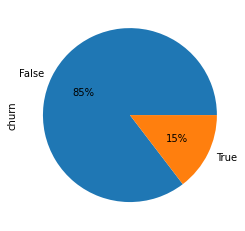

In [71]:
df['churn'].value_counts(normalize=True).plot(kind='pie', autopct=lambda x: f'{x:.0f}%')

# Model Development & Testing

In [75]:
from sklearn.model_selection import train_test_split

def prepare_Xy(df:pd.DataFrame) -> tuple:
    '''Returns X, X_train, X_test, y, y_train, y_test, categorical_features, train_set, test_set'''
    
    X = df.drop(columns=['churn'])
    y = df['churn'].astype(str)

    categorical_features = [i for i, dtype in enumerate(X.dtypes) if dtype == 'object']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    return X_train, X_test, y_train, y_test, categorical_features

X_train, X_test, y_train, y_test, categorical_features = prepare_Xy(df)

In [76]:
y_test.value_counts(normalize=True)

False    0.845
True     0.155
Name: churn, dtype: float64

In [77]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(metric_period=100)

model.fit(X_train, y_train, cat_features=categorical_features)

Learning rate set to 0.014969
0:	learn: 0.6754231	total: 7.95ms	remaining: 7.94s
100:	learn: 0.2143427	total: 507ms	remaining: 4.51s
200:	learn: 0.1511894	total: 822ms	remaining: 3.27s
300:	learn: 0.1276691	total: 1.14s	remaining: 2.64s
400:	learn: 0.1133638	total: 1.49s	remaining: 2.23s
500:	learn: 0.1021986	total: 1.85s	remaining: 1.84s
600:	learn: 0.0932877	total: 2.13s	remaining: 1.42s
700:	learn: 0.0861769	total: 2.49s	remaining: 1.06s
800:	learn: 0.0791405	total: 2.76s	remaining: 686ms
900:	learn: 0.0724104	total: 3.08s	remaining: 338ms
999:	learn: 0.0663844	total: 3.37s	remaining: 0us


In [78]:
model.score(X_test, y_test)

0.955

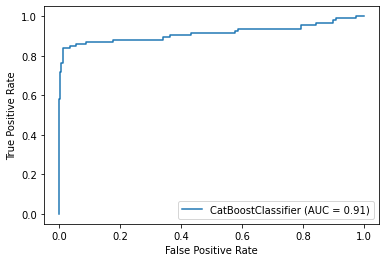

In [79]:
from sklearn.metrics import plot_roc_curve, roc_auc_score

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


plot_roc_curve(model, X_test, y_test)

# Exporting the Model

In [80]:
model.save_model('catboost_model.cbm', format='cbm', pool=train_set)